In [1]:
import sklearn
import scipy
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("data/model_building_df.csv", dtype = str)

#convert diabetes label to 0 or 1 
#also make a dataframe called 'labels' to use for testing
df['diabetes'] = df['diabetes'].replace('Case', 1)
df['diabetes'] = df['diabetes'].replace('Control', 0)
labels = df['diabetes'].values.astype(int)

#drop diabetes status from dataframe
df = df.drop(['diabetes'], axis = 1)

#make a list with the cat vars in the dataframe (all of them except 'age')
#all of the variables, apart from age, in the model_building_df file are categorical
cat_vars = []
for line in df:
    cat_vars.append(line)
    
cat_vars.remove('age_at_diagnosis')

In [3]:
#this section is for converting age to a categorical variable if desired (optional)
ages = df['age_at_diagnosis'].astype(dtype = 'float').values

def age2cat(age):
    if age < 40:
        return '0'
    elif 40 <= age < 50:
        return '1'
    elif 50 <= age < 60:
        return '2'
    else:
        return '3'

new_ages = []
for age in ages:
    new_age = age2cat(age)
    new_ages.append(new_age)
new_ages = np.array(new_ages)

df['cat_age'] = new_ages
cat_vars.append('cat_age')
cat_df = df[cat_vars]

In [4]:
#encoding of the cat variables
#ohe_cat_vars is the dataset that will be used
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories = 'auto')
ohe_cat_vars = ohe.fit_transform(cat_df).toarray()

#these steps make a list called 'new_feature_names' that will be used later to show the top features for the model
feature_names = ohe.get_feature_names()

new_feature_names = []
for each in feature_names:
    nm, lvl = each.split("_")
    idx = int(nm[1:])
    cat_name = cat_vars[idx]
    new_feature_name = "{}_{}".format(cat_name, lvl)
    new_feature_names.append(new_feature_name)

In [5]:
#oversampling step because the dataset is imbalanced
#the documentation for imblearn and RandomOverSampler specifically can be found here: https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html
#this method randomly draws samples from the minority class without replacement until the number of majority/minority samples is approximately the same
#if desired, there are other oversampling methods in the imblearn package 

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

oversample = RandomOverSampler(sampling_strategy = "minority")
model_vars_over, labels_over = oversample.fit_resample(ohe_cat_vars, labels)

#train test split, stratified by class
train_x, test_x, train_y, test_y = train_test_split(model_vars_over, labels_over, test_size = 0.2, random_state = 42, shuffle = True, stratify = labels_over)

In [6]:
#cross-validation step
#different scoring parameters can be used (e.g. 'f1', 'precision', 'recall', etc.)
#n_splits = 5 means five-fold CV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

def five_fold_CV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring = 'f1', n_jobs = -1,
                                  cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),
                                  verbose = 1, iid = True, n_iter = 20, refit = True)

    cv_model.fit(dx, dy)

    return cv_model.best_estimator_, cv_model.best_score_

In [7]:
#defining the plot_auc_roc and get_Younden_idx functions that will be called by the roc_auc_analysis function

import matplotlib.pyplot as plt

def plot_auc_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.4f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def get_Younden_idx(fpr, tpr, threshold):
    idx = np.argmax(np.abs(tpr-fpr))
    return threshold[idx]

In [8]:
#this function plots the roc curve and reads out various metrics (e.g. precision, recall, etc.)
#notice the difference between the variables 'preds' and 'pred_labels'
#preds being probabilities and pred_labels being the predicted classifier (1 or 0)

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

def roc_auc_analysis(clf, dx, dy):
    preds = clf.predict_proba(dx)
    pred_labels = clf.predict(dx)
    preds = list(map(lambda x: x[-1], preds))
    fpr, tpr, threshold = roc_curve(dy, preds)
    plot_auc_roc(fpr, tpr)
    print("first three predicted probabilities: ", preds[:3])
    print("roc_auc_score: ", roc_auc_score(dy, preds))
   
    #applying the Younden index to increase accuracy (we can exclude this from the final model probably)
    J  = get_Younden_idx(fpr, tpr, threshold)
    print("Youden index: ", J)
    youden_preds = list(map(lambda x: 1 if x >= J else 0, preds))
    print("first three youden predicted results: ", youden_preds[:3])          
    print("accuracy after apply youden index: ", accuracy_score(dy, youden_preds))
   
    #traditional evaluation metrics (feel free to add more)
    print("precision: ", precision_score(dy, pred_labels, average = 'macro'))
    print("recall: ", recall_score(dy, pred_labels, average = 'macro'))


    if isinstance(clf, LogisticRegression):
        cof = clf.coef_.tolist()[0]
        cof_idx = list(zip(cof, range(len(cof))))
        top_5_fea = sorted(cof_idx, key=lambda x: abs(x[0]), reverse=True)[:5]
#    elif isinstance(clf, RandomForestClassifier):
#        fea_imp = clf.feature_importances_
#        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, XGBClassifier):
        fea_imp = clf.feature_importances_
        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    else: # SVM
        # for SVM with RGB kernel, this is no straightforward way to get feature improtance
        # https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses
        pass
        top_5_fea = []
    
    #shows top 5 features (this can be expanded to include more features, you have to tweak the number in the brackets at the end of the top_5_fea variable in the if statements above)
    #you also have to tweak the number in the parantheses of the round() below
    print("top 5 features: ", list(map(lambda x: (new_feature_names[x[1]], round(x[0], 4)), top_5_fea)))

In [9]:
#random forest

In [10]:
#svm

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
C:\Users\f.dastmalchi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
C:\Users\f.dastmalchi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


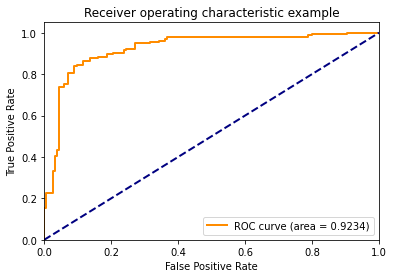

first three predicted probabilities:  [0.2890060613326741, 0.2552735773376314, 0.22239408719774448]
roc_auc_score:  0.9233766233766234
Youden index:  0.44996675354662286
first three youden predicted results:  [0, 0, 0]
accuracy after apply youden index:  0.8737864077669902
precision:  0.8699974670719351
recall:  0.8671763720150817
top 5 features:  [('malaise_and_fatigue_1', 0.1793), ('malaise_and_fatigue_0', -0.1793), ('pure_hypercholesterolemia_1', 0.1518), ('pure_hypercholesterolemia_0', -0.1518), ('hypothyroidism_1', 0.1391)]


In [11]:
#logistic regression
#As of yet, I have not found default parameters for the search space.
#Because of this, I'm just using the distributions that Mr. Yang used in the previous lecture for logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = "saga", max_iter = 100, random_state=13)

#define search space hyperparameter ranges
params_lr = {'max_iter': [10, 50, 100, 200, 500, 750, 1000], 
                    'tol': [0.0001, 0.001, 0.01, 0.1],
                    'C': [0.01, 0.1, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0],
                    'solver': ['lbfgs', 'liblinear', 'newton-cg'], 
                    'class_weight': [None, 'balanced']}

best_lr_model, best_cv_performance = five_fold_CV(lr, params_lr, train_x, train_y)
best_lr_model, best_cv_performance = five_fold_CV(lr, params_lr, test_x, test_y)

roc_auc_analysis(best_lr_model, test_x, test_y)

# XGBoost

In [12]:
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
#               min_child_weight=1, missing=nan, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
C:\Users\f.dastmalchi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


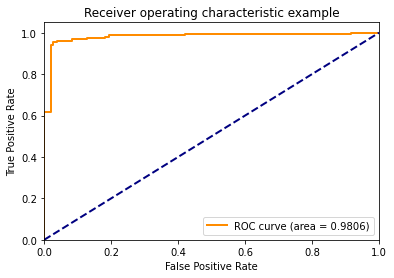

first three predicted probabilities:  [0.087448776, 0.037837394, 0.02214999]
roc_auc_score:  0.9806451612903226
Youden index:  0.20468727
first three youden predicted results:  [0, 0, 0]
accuracy after apply youden index:  0.9644012944983819
precision:  0.950189393939394
recall:  0.9481147884373691
top 5 features:  [('malaise_and_fatigue_0', 0.3409), ('atrial_fibrillation_0', 0.0835), ('a1c_test_0', 0.057), ('pure_hypercholesterolemia_0', 0.0472), ('hypothyroidism_0', 0.0391)]


In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

#define search space hyperparameter ranges
params_xgb = {'n_estimators': [10, 50, 100], 
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.1, 0.3, 0.5]}

best_xgb_model, best_cv_performance = five_fold_CV(xgb, params_xgb, train_x, train_y)

roc_auc_analysis(best_xgb_model, test_x, test_y)

In [14]:
# Calculate F1 score
from sklearn.metrics import f1_score

y_pred = best_xgb_model.predict(test_x)
y_true = test_y
f1_score(y_true, y_pred)

0.9463087248322148

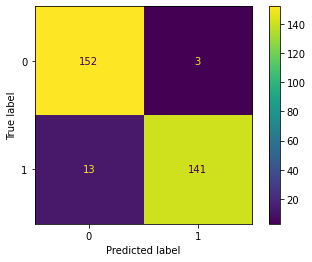

In [15]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# print(confusion_matrix(y_true, y_pred))

plot_confusion_matrix(best_xgb_model, test_x, test_y);
plt.grid(False)

In [16]:
# Extract top 10 impostant features 
f_imp = sorted(zip(best_xgb_model.feature_importances_, new_feature_names))[::-1][:10]

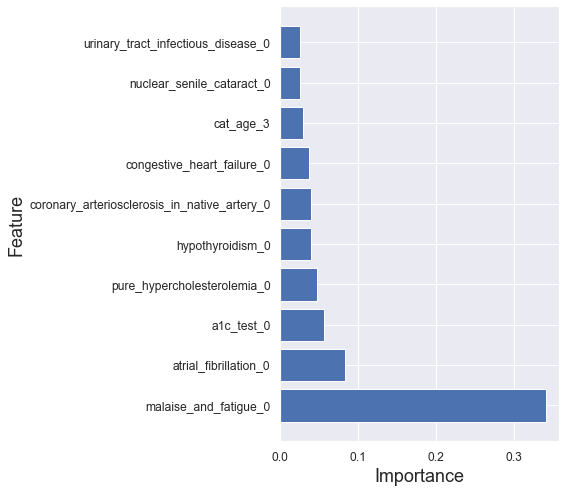

In [17]:
# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'lines.linewidth': 1, 'lines.markersize': 10})
sns.set(style="darkgrid", font_scale=1.1)

plt.figure(figsize=(5, 8))

plt.barh([i[1] for i in f_imp], [i[0] for i in f_imp])
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.show()